<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1d_LSTM_CNC_without_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=c5bafb798bbb6e28ea522ef3c836899d2cf9d5371ed310a89183e188d218fa11
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [70]:
import yfinance as yf
daily_data = yf.download(tickers='AAPL', period = '2000d', interval = '1d')
daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-14,18.671785,18.902857,18.638214,18.862858,16.750263,282419200
2013-11-15,18.806429,18.896070,18.731787,18.749643,16.649729,317920400
2013-11-18,18.749643,18.828215,18.507143,18.522499,16.448029,244944000
2013-11-19,18.536785,18.692142,18.498928,18.555357,16.477203,208938800
2013-11-20,18.543928,18.586430,18.368929,18.392857,16.332909,193916800
...,...,...,...,...,...,...
2021-10-19,147.009995,149.169998,146.550003,148.759995,148.759995,76378900
2021-10-20,148.699997,149.750000,148.119995,149.259995,149.259995,58418800
2021-10-21,148.809998,149.639999,147.869995,149.479996,149.479996,61421000


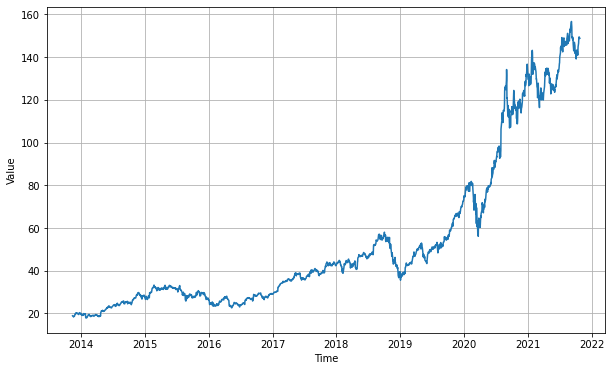

In [71]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(daily_data.Close)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [72]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [73]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [74]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [75]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 4s 67ms/step - loss: 45.4400 - mae: 45.9371
Epoch 2/100
4/4 [==============================] - 0s 37ms/step - loss: 45.0628 - mae: 45.5598
Epoch 3/100
4/4 [==============================] - 0s 39ms/step - loss: 44.3584 - mae: 44.8554
Epoch 4/100
4/4 [==============================] - 0s 38ms/step - loss: 43.3655 - mae: 43.8624
Epoch 5/100
4/4 [==============================] - 0s 39ms/step - loss: 42.0806 - mae: 42.5773
Epoch 6/100
4/4 [==============================] - 0s 40ms/step - loss: 40.4989 - mae: 40.9954
Epoch 7/100
4/4 [==============================] - 0s 41ms/step - loss: 38.5867 - mae: 39.0829
Epoch 8/100
4/4 [==============================] - 0s 41ms/step - loss: 36.2944 - mae: 36.7906
Epoch 9/100
4/4 [==============================] - 0s 43ms/step - loss: 33.5564 - mae: 34.0529
Epoch 10/100
4/4 [=========================

(1e-08, 0.001, 0.0, 25.0)

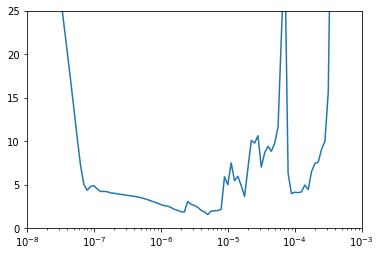

In [76]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 25])

In [77]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 4s 37ms/step - loss: 13.1703 - mae: 13.6588
Epoch 2/150
10/10 [==============================] - 1s 35ms/step - loss: 4.8395 - mae: 5.3225
Epoch 3/150
10/10 [==============================] - 1s 36ms/step - loss: 2.6776 - mae: 3.1437
Epoch 4/150
10/10 [==============================] - 1s 35ms/step - loss: 1.6970 - mae: 2.1395
Epoch 5/150
10/10 [==============================] - 1s 36ms/step - loss: 1.1903 - mae: 1.6133
Epoch 6/150
10/10 [==============================] - 1s 37ms/step - loss: 0.9485 - mae: 1.3498
Epoch 7/150
10/10 [==============================] - 1s 36ms/step - loss: 0.8202 - mae: 1.2144
Epoch 8/150
10/10 [==============================] - 1s 36ms/step - loss: 0.6830 - mae: 1.0604
Epoch 9/150
10/10 [==============================] - 1s 37ms/step - loss: 0.6131 - mae: 0.9835
Epoch 10/150
10/10 [==============================] - 1s 35ms/step - loss: 0.5705 - mae: 0.9395
Epoch 11/150
10/10 [===========================

In [78]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

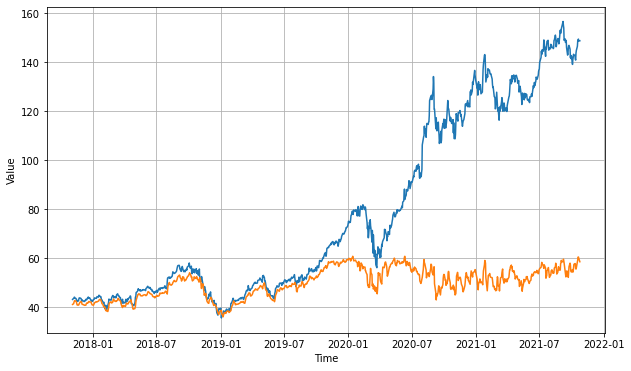

In [79]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS